In [1]:
from plot_utils import *

# The sync greedy algorithm (Part1)

## Empirics

In [2]:
"""
df_sync_eo = load_df('sync-eo-vary-h')
df_sync_eo = df_sync_eo.groupby(['n','h']).head(800)
df_sync_eo = df_sync_eo.groupby(['n', 'h']).mean().reset_index()
ok_h = list(set(np.concatenate([np.linspace(-0.6,0.0,90),np.linspace(0.2,0.5,45),np.linspace(0.0,0.2,30)])))
df_sync_eo = df_sync_eo[df_sync_eo.h.isin(ok_h)]
df_sync_eo.to_csv(CLEAN_DIR / 'empirircs_sync_eo.csv',index=None)
"""

df_sync_eo = pd.read_csv(CLEAN_DIR / 'empirircs_sync_eo.csv')

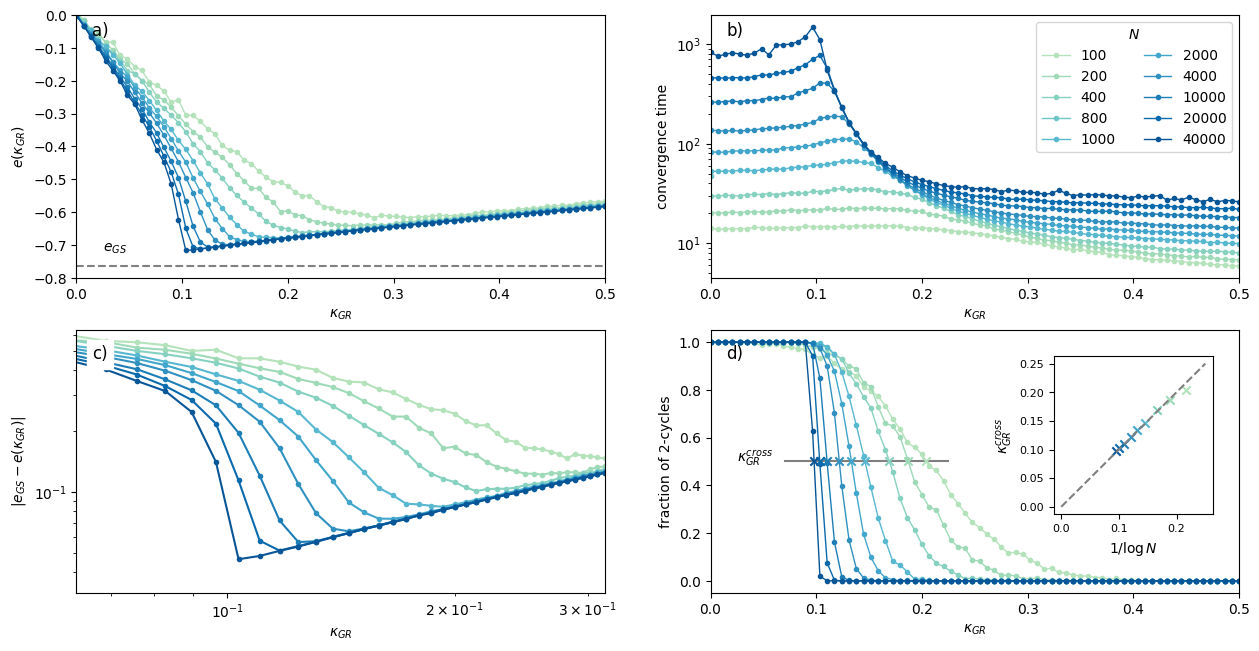

In [3]:
fig, axes = plt.subplots(2,2,figsize=(3*width,2.5*height))
axes = axes.flatten()


###### colors

cmap = mpl.colormaps['GnBu']
ns = df_sync_eo.n.unique()
offset=5
colors = {n:cmap((i+offset)/(len(ns)+5)) for i, n in enumerate(sorted(ns))}


###### inset
offset_x = 0.65
offset_y = 0.3
position = axes[3].get_position()
inset_width = 0.3 * position.width
inset_height = 0.6 * position.height
inset_x = position.x0 + offset_x * position.width
inset_y = position.y0 + offset_y * position.height
ax_inset = fig.add_axes([inset_x, inset_y, inset_width, inset_height])


#### energy
ns = []
emins = []
kappas = []
ax = axes[0]
for n, g in df_sync_eo.groupby('n'):
    ax.plot(g['h'], g['energy'],lw=1,color=colors[n],marker='.')
    idx = g.energy.idxmin()
    ns.append(n)
    emins.append(g.loc[idx].energy)
    kappas.append(g.loc[idx].h)
plot_GS(ax)
ax.text(0.05, 0.1, '$e_{GS}$', fontsize=10, transform=ax.transAxes)
ax.set_ylabel('$e(\kappa_{GR})$')
ax.set_xlabel(kappa_eo_str)
ax.set_ylim(-0.8,0.0)

x = np.linspace(0,0.25,100)
y = 0.44 * x - gs
ax.set_xlim(-0.0,0.5)


#### transient

ax = axes[1]
for n, g in df_sync_eo.groupby('n'):
    ax.plot(g['h'], g['transient'], label=f'{n}',lw=1,color=colors[n],marker='.')

ax.legend(title='$N$',loc='upper right', ncol=2)
ax.set_xlabel(kappa_eo_str)
ax.set_ylabel('convergence time')
ax.set_yscale('log')
ax.set_xlim(-0.0,0.5)


#### cycles

ax = axes[3]
x = np.linspace(0,0.25,100)

ax_inset.plot(x,x,c='grey',linestyle='dashed')
for n, g in df_sync_eo.groupby('n'):
    ax.plot(g['h'], g['c']-1, label=f'{n}',lw=1,color=colors[n],marker='.')
    if not np.isnan(g[g.c < 1.03].h.min()):
        idx = g[g.c > 1.5].h.idxmax()
        k_max = g.loc[idx].h
        c_max = g.loc[idx].c
        idx = g[g.c < 1.5].h.idxmin()
        k_min = g.loc[idx].h
        c_min = g.loc[idx].c
        
        xx =k_min+(k_max-k_min)/2
        yy = c_min+(c_max-c_min)/2

        xx, _  = find_intersection_point(k_max,c_max, k_min,c_min,1.5)
        ax_inset.scatter([1/np.log(n)],[xx],marker='x',color=colors[n])
        ax.scatter([xx],[0.5],marker='x',color=colors[n])


ax.set_xlabel(kappa_eo_str)
ax.set_ylabel('fraction of 2-cycles')
ax.set_xlim(-0.0,0.5)
ax.text(0.05, 0.5, '$\kappa_{GR}^{cross}$', fontsize=10, transform=ax.transAxes)
ax.plot([0.14,0.45],[0.5,0.5],transform=ax.transAxes,c='grey',zorder=-100)

ax_inset.tick_params(axis='both',  labelsize=8)
ax_inset.tick_params(axis='both',  which='minor',labelsize=8)
ax_inset.xaxis.label.set_size(10)
ax_inset.yaxis.label.set_size(10)
ax_inset.set_xlabel('$1/\log N$')
ax_inset.set_ylabel('$\kappa_{GR}^{cross}$')

##### log zoom energy

ax = axes[2]
for n, g in df_sync_eo.groupby('n'):
    ax.plot(g.h,g.energy+gs,marker='.',color=colors[n])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(np.power(10,-1.2),np.power(10,-0.5))
ax.set_ylim(np.power(10,-1.5),np.power(10,-0.2))
ax.set_xlabel(kappa_eo_str)
ax.set_ylabel('$|e_{GS} - e(\kappa_{GR})|$')

#### labels 

axes[0].text(0.03, 0.92, f'a)', fontsize=12, transform=axes[0].transAxes)
axes[1].text(0.03, 0.92, f'b)', fontsize=12, transform=axes[1].transAxes)
axes[2].text(0.03, 0.89, f'c)', fontsize=12, transform=axes[2].transAxes,backgroundcolor='white',alpha=1.0)
axes[3].text(0.03, 0.89, f'd)', fontsize=12, transform=axes[3].transAxes)

plt.savefig(save_dir / 'Fig_3_empirics_SYNC_EO_overview.png',dpi=300,bbox_inches='tight')

## DMFT

###  Forward

In [4]:
times_wanted = [0,1,2,3,4,5,6,10,20,50,150,390]

In [5]:
#"""
df_empirics_forward_dcm = load_df('sync-eo-compare-dcm')
df_empirics_forward_dcm = df_empirics_forward_dcm[df_empirics_forward_dcm.n == 2000].groupby('h').head(3000)
df_empirics_forward_dcm = df_empirics_forward_dcm[df_empirics_forward_dcm.energy_trajectory.apply(len) > 0]

def get_energy_at(g,i):
    g = g[g.apply(len) > i]
    e = g.apply(lambda x: x[i]).mean()
    return e

df_empirics_forward_dcm_cols = []
for i in times_wanted:
    s = df_empirics_forward_dcm.groupby('h').agg(x=('energy_trajectory',lambda x: get_energy_at(x,i))).reset_index()
    s.columns = ['h',f'energy_{i}']
    df_empirics_forward_dcm_cols.append(s.set_index('h')[f'energy_{i}'])
df_empirics_forward_dcm = pd.DataFrame(df_empirics_forward_dcm_cols).T.reset_index()
df_empirics_forward_dcm.to_csv(CLEAN_DIR / 'df_empirics_forward_dcm_n=2000.csv',index=None)
#"""

df_empirics_forward_dcm = pd.read_csv(CLEAN_DIR / 'df_empirics_forward_dcm_n=2000.csv')

Loading raw results


In [6]:
df = pd.read_csv('results/theory/fd_eo_energy.csv')
res = []
for i, row in df.iterrows():
    for p, e in enumerate(ast.literal_eval(row.energy.replace('NaN','-1'))):
        res.append({'keo': row.keo,'energy':np.nan if e == -1 else e,'p':p})
df_theory_forward_dcm = pd.DataFrame(res).sort_values(by='keo')


df_theory_pxh = pd.read_csv('results/theory/bk_pdfxh_c1_keo0.csv')
df_theory_pxh.pdf_xh_values = df_theory_pxh.pdf_xh_values.apply(ast.literal_eval)
df_theory_pxh.pdf_y_values = df_theory_pxh.pdf_y_values.apply(ast.literal_eval)
df_theory_pxh.set_index('p',inplace=True)

In [7]:
df_theory_back_dcm = pd.read_csv('results/theory/data_syncGR_BK.csv') 

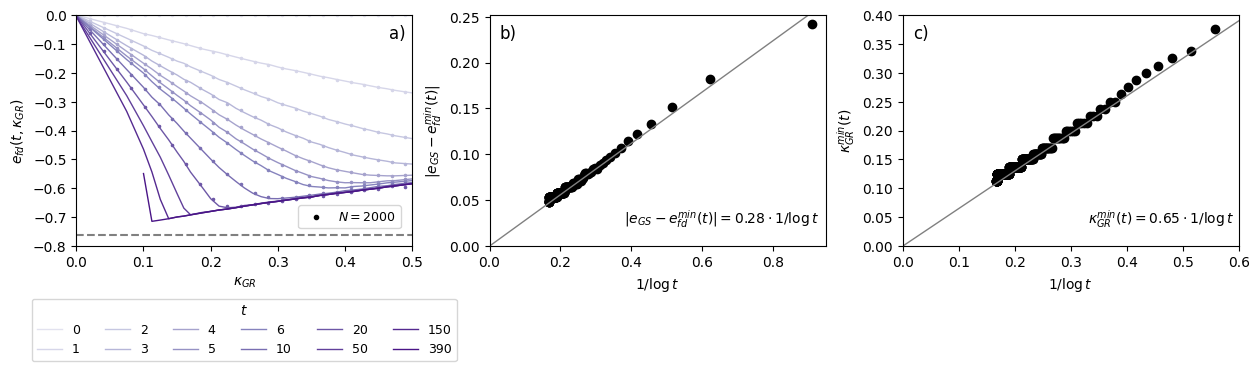

In [8]:
fig, axes = plt.subplots(1,3,figsize=(3*width,1*height))
#### energy f

ax = axes[0]


# plot first k steps
ps = range(300)
for i in times_wanted:
    ax.scatter(df_empirics_forward_dcm.h,df_empirics_forward_dcm[f'energy_{i}'],marker='.',s=10,color=colors_fwd[i])
    
for p, g in df_theory_forward_dcm.groupby('p'):
    if p not in times_wanted:
        continue
    ax.plot(g.keo,-g.energy,lw=1,color=colors_fwd[p])
    

plot_GS(ax,nolabel=True)
ax.set_xlabel(kappa_eo_str)
ax.scatter([],[],marker='.',c='black',label='$N=2000$')
legend1 = ax.legend(fontsize=legend_fontsize,loc='lower right', bbox_to_anchor=(0.985, 0.05))
ax.set_ylabel('$e_{fd}(t,\kappa_{GR})$')
ax.set_ylim(-0.8,0.0)
ax.set_xlim(0,0.5)
#x = np.linspace(0,1.5,100)
#y = 0.38 * x - gs
#ax.plot(x,y,c='grey',lw=1)
ax = axes[0]
artists = []
labels = []
for p, g in df_theory_forward_dcm.groupby('p'):
    if p not in times_wanted:
        continue
    artists.append(ax.plot([],[],label=p,lw=1,color=colors_fwd[p])[0])
    labels.append(p)
ax.legend(artists,labels,title=p_forward,fontsize=legend_fontsize,ncol=6,loc='upper center', bbox_to_anchor=(0.5, -0.2))
ax.add_artist(legend1)

ax = axes[1]
a = df_theory_forward_dcm[df_theory_forward_dcm.energy>0]
a = a[a.energy<1.0]
a = a[a.p>0]
g = a.groupby('p').energy.max().reset_index()
g = g[::2]

ax.scatter(1/np.log(g.p),-g.energy+gs,c='black')
#ax.set_yscale('log')
#ax.set_xscale('log')
#b, c = power_law_fit(g.p.astype(float), -g.energy.values, gs)
x = np.linspace(1,100,100)
#ax.plot(1/x,b*x**(-c),lw=1,c='grey')
ax.set_ylabel('$|e_{GS} - e_{fd}^{min}(t)|$')
ax.set_xlabel('$1/\log t$')
ax.set_ylim(0)
ax.set_xlim(0)
x = np.linspace(0,1)
ax.plot(x,0.28*x,lw=1,c='grey')
ax.text(0.4, 0.1, '$|e_{GS} - e_{fd}^{min}(t)|=0.28\cdot 1/\log t$', fontsize=10, transform=ax.transAxes)


ax = axes[2]
a = df_theory_forward_dcm[df_theory_forward_dcm.energy>0]
a = a[a.energy<1.0]
a = a[a.keo<0.5]
a = a[a.p>0]
a = a.reset_index()
g = a.groupby('p').energy.idxmax()#.reset_index()
r = a.iloc[g]
#ax.scatter(1/np.log(r.p),r.keo)
ax.scatter(1/np.log(r.p),r.keo,c='black')
ax.set_ylabel('$\kappa_{GR}^{min}(t)$')
ax.set_xlabel('$1/\log t$')
x=np.linspace(0,1)
ax.plot(x,0.65*x,lw=1,c='grey')
ax.text(0.55, 0.1, '$\kappa_{GR}^{min}(t)=0.65\cdot 1/\log t$', fontsize=10, transform=ax.transAxes)
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.4)
plt.subplots_adjust(wspace=0.23)
axes[0].text(0.93, 0.9, f'a)', fontsize=12, transform=axes[0].transAxes)
axes[1].text(0.03, 0.9, f'b)', fontsize=12, transform=axes[1].transAxes)
axes[2].text(0.03, 0.9, f'c)', fontsize=12, transform=axes[2].transAxes)
plt.savefig(save_dir / 'Fig_4FWD_DMFT_SYNC_EO.png',dpi=300,bbox_inches='tight')

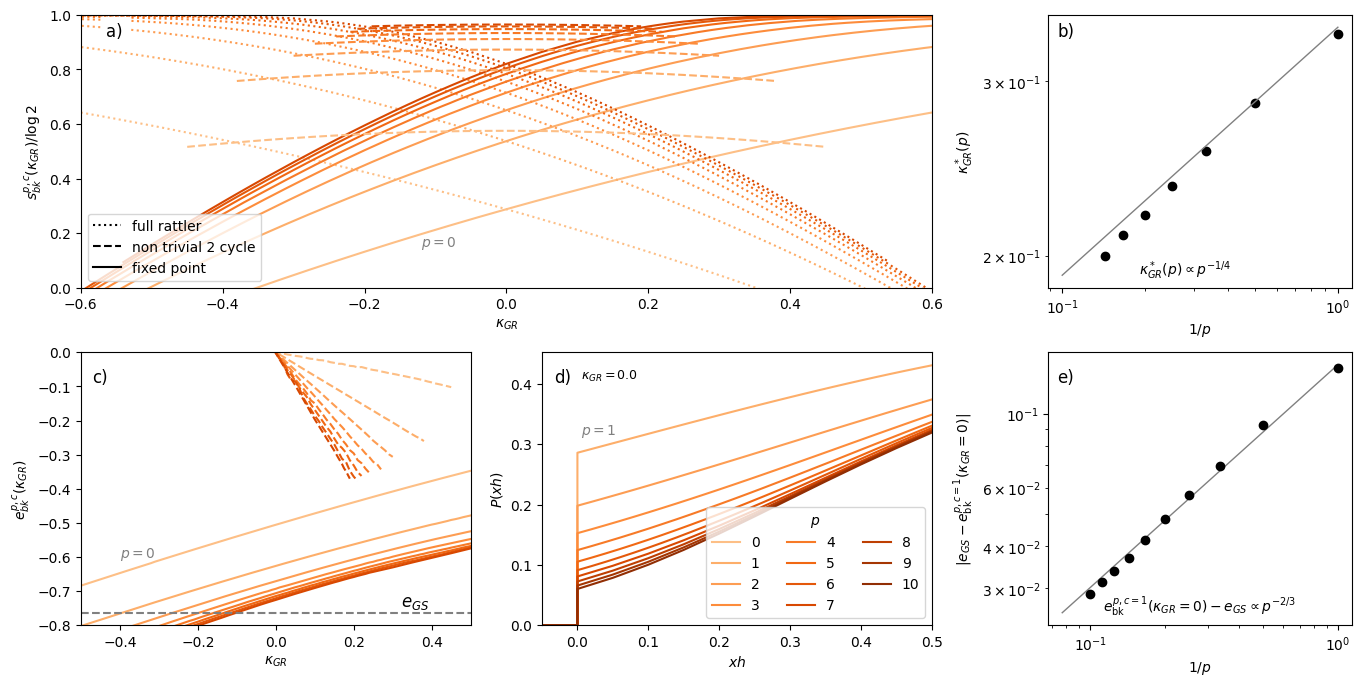

In [9]:
axd = plt.figure(layout="constrained",figsize=(3*0.9*width,2.5*0.9*height)).subplot_mosaic(
    """
    AAB
    CDE
    """,
    height_ratios=[1, 1],
    # set the width ratios between the columns
    width_ratios=[.9, .9,0.7],
    gridspec_kw={
       # "wspace": 0.2,
    },
)
def linestyle(c,bc):
    if bc == -1:
        return 'dotted'
    if c == 1:
        return 'solid'
    
    return 'dashed'
    
#### energy
ax = axd['C']
n=100
      
for (c,p,bc), g in df_theory_back_dcm.groupby(['c','p','bc']):
    ax.plot(g.keo,g.energy,color=colors_bwd[p],linestyle=linestyle(c,bc))
  


ax.set_xlabel('$\kappa_{GR}$')
ax.set_ylabel('$e_{bk}^{p,c}(\kappa_{GR})$')
ax.set_xlim(-0.5,0.5)
ax.set_ylim(-0.8,0.0)
plot_GS(ax,nolabel=True)
ax.text(0.82, 0.07, '$e_{GS}$', fontsize=12, transform=ax.transAxes)

#### entropy

ax = axd['A']
    
for (c,p,bc), g in df_theory_back_dcm.groupby(['c','p','bc']):
    ax.plot(g.keo,g.norm_entropy,color=colors_bwd[p],linestyle=linestyle(c,bc))
ax.plot([],[],  color='black',linestyle='dotted',label='full rattler' )
ax.plot([],[],  color='black',linestyle='dashed',label='non trivial 2 cycle')
ax.plot([],[],  color='black',label='fixed point')
 
ax.legend(loc='lower left')
ax.set_xlabel('$\kappa_{GR}$')
ax.set_ylabel('$s_{bk}^{p,c}(\kappa_{GR})/\log 2$')
ax.set_xlim(-0.6,0.6)
ax.set_ylim(0.0,1.0)

ax = axd['E']
df_energy = pd.read_csv('results/theory/fit_e_vs_p.csv')
df_energy = df_energy[df_energy.p>0]
b, c = power_law_fit(df_energy.p.values.astype(float), -df_energy.max_energy.values, gs)#, initial_guess=(20.0, 0.75))
x = np.linspace(1,13,100)
c = 2/3
b = 0.14
ax.plot(1/x,b*x**(-c),lw=1,c='grey')
ax.scatter(1/df_energy.p,-df_energy.max_energy+gs,zorder=100,c='black')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'$|e_{GS} - e_{\rm bk}^{p,c=1}(\kappa_{GR} = 0)|$')
ax.set_xlabel('$1/p$')
ax.text(0.18, 0.05, r'$e_{\rm bk}^{p,c=1}(\kappa_{GR} = 0) - e_{GS} \propto p^{-2/3}$', fontsize=10, transform=ax.transAxes)


###

ax = axd['B']
x = np.linspace(0,1,100)
p = np.arange(8)
kappas = np.array([0.385, 0.335, 0.285, 0.255, 0.235, 0.22, 0.21, 0.2])
ax.scatter(1/p[1:],kappas[1:],c='black')
b, c = power_law_fit(p[1:], kappas[1:], 0, initial_guess=(0.33, 0.25))
b = 0.34
c = 1/4
x = np.linspace(1,10,100)
ax.plot(1/x,b*x**(-c),lw=1,c='grey')
ax.text(0.3, 0.05, '$\kappa_{GR}^*(p) \propto p^{-1/4}$', fontsize=10, transform=ax.transAxes)

ax.set_xlabel('$1/p$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$\kappa_{GR}^*(p)$')


###

ax = axd['D']
ax.plot([], [],label=0,color=colors_bwd[0])
for p in range(1,11):
    df = df_theory_pxh.loc[p]
    ax.plot([-0.1,0]+df.pdf_xh_values, [0,0]+df.pdf_y_values,label=p,color=colors_bwd[p])
ax.set_xlabel('$xh$')
ax.set_ylabel('$P(xh)$')
ax.set_ylim(0,)
ax.set_xlim(-0.05,0.5)
ax.legend(title='$p$',ncol=3,loc='lower right')
ax.text(0.1, 0.9, r'$\kappa_{GR}=0.0$', fontsize=9, transform=ax.transAxes)
axes = list(axd.values())
axes[0].text(0.03, 0.92, f'a)', fontsize=12, transform=axes[0].transAxes,backgroundcolor='white',alpha=1.0)
axes[1].text(0.03, 0.92, f'b)', fontsize=12, transform=axes[1].transAxes)
axes[2].text(0.03, 0.89, f'c)', fontsize=12, transform=axes[2].transAxes,backgroundcolor='white',alpha=1.0)
axes[3].text(0.03, 0.89, f'd)', fontsize=12, transform=axes[3].transAxes,backgroundcolor='white',alpha=1.0)
axes[4].text(0.03, 0.89, f'e)', fontsize=12, transform=axes[4].transAxes)

axd['A'].text(0.4, 0.15, f'$p=0$', fontsize=10, transform=axd['A'].transAxes,alpha=1.0,color='grey')
#axd['A'].text(0.1, 0.4, f'$p=7$', fontsize=10, transform=axd['A'].transAxes,alpha=1.0,color='grey')
# Calculate arrow start and end points
start_point = (0.4, 0.17)  # From the first text position
end_point = (0.15, 0.4)      # To the second text position

# Draw the arrow
#axd['A'].annotate('', xy=end_point, xytext=start_point,
#                  arrowprops=dict(facecolor='grey', arrowstyle='->',color='grey'),xycoords='axes fraction', textcoords='axes fraction',color='grey')

axd['C'].text(0.1, 0.25, f'$p=0$', fontsize=10, transform=axd['C'].transAxes,alpha=1.0,color='grey')
axd['D'].text(0.1, 0.7, f'$p=1$', fontsize=10, transform=axd['D'].transAxes,alpha=1.0,color='grey')

plt.savefig(save_dir / 'Fig_4BWD_DMFT_SYNC_EO.png',dpi=300,bbox_inches='tight')

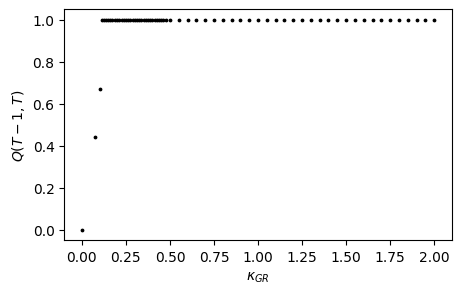

In [10]:
df = pd.read_csv('results/theory/fd_eo_correlation.csv') 
fig, axes = plt.subplots(1,1,figsize=(1*width,1*height))
plt.scatter(df.keo,df.Qendend, c='black',s=3)
plt.xlabel('$\kappa_{GR}$')
plt.ylabel('$Q(T-1,T)$')
plt.savefig(save_dir / 'Fig_AX_sync_eo_fd_corr.png',dpi=300,bbox_inches='tight')